## <font color='Blue'>Introduction</font>
###  In this exercise, we run simulation in a 2D single layer two-phase model.
* Some details of runtime parameters can be found by [DARTS-engine](./darts/html/index.html)

## <font color='blue'>The objectives:</font>
1. Introduce custom <font color='red'>'Model'</font> class based on 
 * Class [DartsModel](http://localhost:8888/edit/darts-workshop/darts/models/darts_model.py) with base model capabilities
 * Class [StructReservoir](http://localhost:8888/edit/darts-workshop/darts/models/reservoirs/struct_reservoir.py) with structured reservoir
 * Class [Deadoil](http://localhost:8888/edit/darts-workshop/darts/models/physics/dead_oil_python.py) for basic dead oil physics
 * Class [Deadoil-properties](http://localhost:8888/edit/darts-workshop/darts/models/physics/do_properties_python.py) for dead oil properties, such as density, viscosity and relative permeability
2. Use run_python procedure to control run from the python script
3. Introduce wells and time-dependent well controls
4. Redefine physical properties and run simulation with custom-defined property.

## <font color='Blue'>Let's start!</font>


<img style="float: left;" src="slides/Slide1.JPG" width="60%">

In [1]:
from darts.models.reservoirs.struct_reservoir import StructReservoir
from darts.models.physics.dead_oil_python import DeadOil
from darts.models.darts_model import DartsModel
from darts.engines import value_vector
from darts.tools.keyword_file_tools import load_single_keyword
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'darts'

<img style="float: left;" src="slides/Slide2.JPG" width="60%">

#### Brief Introduction of model inheritance
* Here create the <font color='red'>'Model' </font>  class, which inherits from <font color='red'>DartsModel</font> (the base class).
* It keeps all the functionalities of <font color='red'>DartsModel</font> and can also be extended to add more functionalities.
* If a function is redefined in subclass, the function in base class with identical name will be overridden.

In [2]:
class Model(DartsModel):
    def __init__(self, perm=None):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = 60
        self.ny = 60
        self.nz = 1
        
        self.dx = 8
        self.dy = 8
        self.dz = 4

        if (perm is None):
            perm = np.ones(self.nx*self.ny)*30
        else:
            perm = perm.reshape(self.nx*self.ny)
            
        self.permx = perm
        self.permy = perm
        self.permz = 0.1 * perm
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth)


        self.reservoir.add_well("INJ1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], 1, 1, 1,  well_index=10)

        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.nx, self.ny, 1, well_index=10)

        # create physics
        self.physics = DeadOil(timer=self.timer, physics_filename='physics.in',
                               n_points=401, min_p=300, max_p=600, min_z=1e-8)

        self.params.first_ts = 1
        self.params.mult_ts = 2
        self.params.max_ts = 50
        self.params.max_i_newton = 100
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-3

        self.inj = [1]

        self.runtime = 1000

        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[0.1])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if w.name[:3] == "INJ":
                w.control = self.physics.new_bhp_water_inj(410, self.inj)
                # w.constraint = self.physics.new_rate_water_prod(210)
            else:
                w.control = self.physics.new_bhp_prod(390)

<img style="float: left;" src="slides/Slide3.JPG" width="60%">

In [3]:
m = Model()
m.init()
m.run_python()
m.print_timers()

Building connection list...
# 1 	T =   1	DT =  1	NI = 2	LI=7
# 2 	T =   3	DT =  2	NI = 1	LI=4
# 3 	T =   7	DT =  4	NI = 1	LI=4
# 4 	T =  15	DT =  8	NI = 1	LI=4
# 5 	T =  31	DT = 16	NI = 1	LI=4
# 6 	T =  63	DT = 32	NI = 1	LI=4
# 7 	T = 113	DT = 50	NI = 1	LI=4
# 8 	T = 163	DT = 50	NI = 1	LI=4
# 9 	T = 213	DT = 50	NI = 1	LI=4
# 10 	T = 263	DT = 50	NI = 1	LI=4
# 11 	T = 313	DT = 50	NI = 1	LI=4
# 12 	T = 363	DT = 50	NI = 1	LI=4
# 13 	T = 413	DT = 50	NI = 1	LI=4
# 14 	T = 463	DT = 50	NI = 2	LI=9
# 15 	T = 513	DT = 50	NI = 2	LI=9
# 16 	T = 563	DT = 50	NI = 2	LI=9
# 17 	T = 613	DT = 50	NI = 2	LI=9
# 18 	T = 663	DT = 50	NI = 2	LI=9
# 19 	T = 713	DT = 50	NI = 2	LI=9
# 20 	T = 763	DT = 50	NI = 2	LI=9
# 21 	T = 813	DT = 50	NI = 2	LI=9
# 22 	T = 863	DT = 50	NI = 2	LI=9
# 23 	T = 913	DT = 50	NI = 2	LI=9
# 24 	T = 963	DT = 50	NI = 2	LI=9
# 25 	T = 1000	DT = 37	NI = 1	LI=4
TS = 25(0), NI = 37(0), LI = 158(0)
Total elapsed 1.089000 sec
	initialization 0.006000 sec
		connection list generation 0.004000 

<img style="float: left;" src="slides/Slide4.JPG" width="60%">

In [4]:
%matplotlib inline
import pandas as pd
time_data = pd.DataFrame.from_dict(m.physics.engine.time_data)
# wirte timedata to output file
time_data.to_pickle("darts_time_data.pkl")
# write timedata to excel file
writer = pd.ExcelWriter('time_data.xlsx')
time_data.to_excel(writer, 'Sheet1')
writer.save()

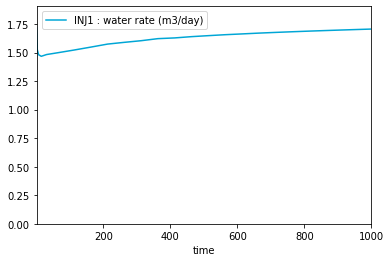

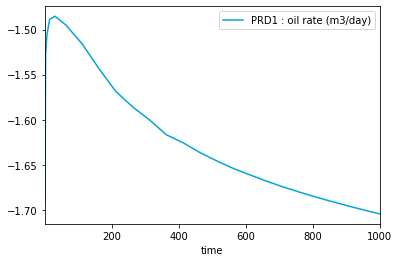

In [5]:
# read data from output file
td = pd.read_pickle("darts_time_data.pkl")
# plot production rates
from darts.tools.plot_darts import *
plot_water_rate_darts('INJ1', time_data)
plot_oil_rate_darts('PRD1', time_data)
plt.show()

<img style="float: left;" src="slides/Slide5.JPG" width="60%">

In [6]:
# process active grid
X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p = X[0:2*nb:2]
z = X[1:2*nb:2]



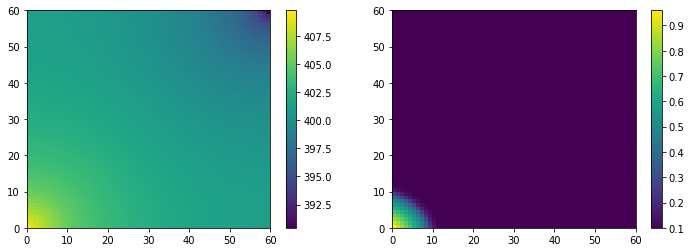

In [7]:
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.colorbar()

plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()

<img style="float: left;" src="slides/Slide6.JPG" width="60%">

In [8]:
perm = load_single_keyword("data.in", "PERMX")
m = Model(perm)
m.init()
m.run()
m.print_timers()

Reading PERMX from C:\Users\raja\Documents\MSc\Q_4\SimulationAndBuildingStratigraphy\Module4\Practical\data.in... 3600 values have been read.
Building connection list...
Total elapsed 1.733000 sec
	initialization 0.011000 sec
		connection list generation 0.005000 sec
	simulation 1.710000 sec
		jacobian assembly 0.628000 sec
			interpolation 0.584000 sec
				acc flux interpolation 0.588000 sec
					body generation 0.545000 sec
						point generation 0.539000 sec
				rate interpolation 0.000000 sec
					body generation 0.000000 sec
						point generation 0.003000 sec
		linear solver setup 0.442000 sec
			GMRES 0.442000 sec
				CPR 0.442000 sec
					AMG 0.384000 sec
					ILU(0) 0.040000 sec
		linear solver solve 0.524000 sec
			GMRES 0.524000 sec
				CPR 0.427000 sec
					AMG 0.266000 sec
					ILU(0) 0.090000 sec
		newton update 0.085000 sec
			composition correction 0.059000 sec



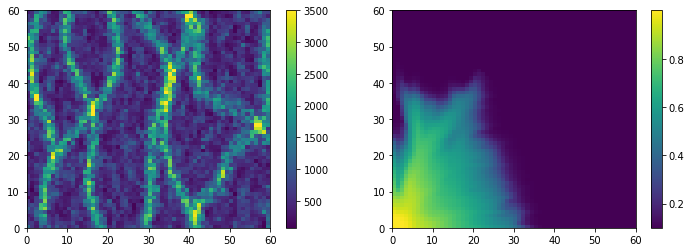

In [11]:
# process active grid
X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p = X[0:2*nb:2]
z = X[1:2*nb:2]

# plot solution
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(m.permx.reshape(m.ny, m.nx))
plt.colorbar()

plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()